# Day 20: Trench Map

## Part 1

With the scanners fully deployed, you turn their attention to mapping the floor of the ocean trench.

When you get back the image from the scanners, it seems to just be random noise. Perhaps you can combine an image enhancement algorithm and the input image (your puzzle input) to clean it up a little.

For example:
```
..#.#..#####.#.#.#.###.##.....###.##.#..###.####..#####..#....#..#..##..##
#..######.###...####..#..#####..##..#.#####...##.#.#..#.##..#.#......#.###
.######.###.####...#.##.##..#..#..#####.....#.#....###..#.##......#.....#.
.#..#..##..#...##.######.####.####.#.#...#.......#..#.#.#...####.##.#.....
.#..#...##.#.##..#...##.#.##..###.#......#.#.......#.#.#.####.###.##...#..
...####.#..#..#.##.#....##..#.####....##...##..#...#......#.#.......#.....
..##..####..#...#.#.#...##..#.#..###..#####........#..####......#..#

#..#.
#....
##..#
..#..
..###
```

The first section is the **image enhancement algorithm**. It is normally given on a single line, but it has been wrapped to multiple lines in this example for legibility. The second section is the **input image**, a two-dimensional grid of **light pixels** (```#```) and **dark pixels** (```.```).

The image enhancement algorithm describes how to enhance an image by **simultaneously** converting all pixels in the input image into an output image. Each pixel of the output image is determined by looking at a 3x3 square of pixels centered on the corresponding input image pixel. So, to determine the value of the pixel at (5,10) in the output image, nine pixels from the input image need to be considered: (4,9), (4,10), (4,11), (5,9), (5,10), (5,11), (6,9), (6,10), and (6,11). These nine input pixels are combined into a single binary number that is used as an index in the **image enhancement algorithm** string.

For example, to determine the output pixel that corresponds to the very middle pixel of the input image, the nine pixels marked by ```[...]``` would need to be considered:
```
# . . # .
#[. . .].
#[# . .]#
.[. # .].
. . # # #
```

Starting from the top-left and reading across each row, these pixels are ```...```, then ```#..```, then ```.#.```; combining these forms ```...#...#..``` By turning dark pixels (```.```) into ```0``` and light pixels (```#```) into ```1```, the binary number ```000100010``` can be formed, which is ```34``` in decimal.

The image enhancement algorithm string is exactly 512 characters long, enough to match every possible 9-bit binary number. The first few characters of the string (numbered starting from zero) are as follows:
<pre>
0         10        20        30  <b>34</b>    40        50        60        70
|         |         |         |   <b>|</b>     |         |         |         |
..#.#..#####.#.#.#.###.##.....###.<b>#</b>#.#..###.####..#####..#....#..#..##..##
</pre>
In the middle of this first group of characters, the character at index 34 can be found: ```#```. So, the output pixel in the center of the output image should be ```#```, a **light pixel**.

This process can then be repeated to calculate every pixel of the output image.

Through advances in imaging technology, the images being operated on here are **infinite** in size. **Every** pixel of the infinite output image needs to be calculated exactly based on the relevant pixels of the input image. The small input image you have is only a small region of the actual infinite input image; the rest of the input image consists of dark pixels (```.```). For the purposes of the example, to save on space, only a portion of the infinite-sized input and output images will be shown.

The starting input image, therefore, looks something like this, with more dark pixels (```.```) extending forever in every direction not shown here:
```
...............
...............
...............
...............
...............
.....#..#......
.....#.........
.....##..#.....
.......#.......
.......###.....
...............
...............
...............
...............
...............
```

By applying the image enhancement algorithm to every pixel simultaneously, the following output image can be obtained:
```
...............
...............
...............
...............
.....##.##.....
....#..#.#.....
....##.#..#....
....####..#....
.....#..##.....
......##..#....
.......#.#.....
...............
...............
...............
...............
```

Through further advances in imaging technology, the above output image can also be used as an input image! This allows it to be **enhanced a second time**:
```
...............
...............
...............
..........#....
....#..#.#.....
...#.#...###...
...#...##.#....
...#.....#.#...
....#.#####....
.....#.#####...
......##.##....
.......###.....
...............
...............
...............
```

Truly incredible - now the small details are really starting to come through. After enhancing the original input image twice, **```35```** pixels are lit.

Start with the original input image and apply the image enhancement algorithm twice, being careful to account for the infinite size of the images. **How many pixels are lit in the resulting image?**

In [1]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
def load_image(path):
    file = open(path,"r")

    data = open("day20_data.txt","r")
    enhancement_str, image = file.read().split("\n\n")
    #print(enhancement_str,len(enhancement_str))
    enhancement_str = np.array([str(int(c == "#")) for c in enhancement_str])
    image = np.array([[str(int(y == "#")) for y in x] for x in image.split("\n")])
    
    #print(enhancement_str)
    #print(image)
    return enhancement_str, image


In [3]:
def get_neighbours(x, y):
    return [
        (x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
        (x    , y - 1), (x    , y), (x    , y + 1),
        (x + 1, y - 1), (x + 1, y), (x + 1, y + 1),
    ]

def bin2dec(binary):
    decimal = int(binary, 2)
    return decimal
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', '0')
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    return vector

In [4]:
def enhance_image(image, enhancement, iterations, verbose: bool = False, video_name: str = None):
    background = '0'
    
    if verbose:
            plt.imshow(np.pad(image.astype(int),iterations,pad_with))
            plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
            plt.show()
    
    if video_name:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(video_name, fourcc, 10, (800,800), True)
        first_frame = np.array(Image.fromarray(np.pad(image.astype(np.uint8)*255,iterations,pad_with)).resize([800,800],Image.BOX))
        first_frame_color = cv2.applyColorMap(first_frame, cv2.COLORMAP_VIRIDIS)
        out.write(first_frame_color)
        
        
    for iters in range(iterations):
        n, m = np.shape(image)
        new_image = np.pad(image, 1, pad_with)
        
        for i in range(-1, m + 1):
            for j in range(-1, n + 1):
                nums = []
                
                neighbours = get_neighbours(i,j)
                
                for neighb in neighbours:
                    if 0 <= neighb[0] < m and 0 <= neighb[1] < n:
                        val = image[neighb[0], neighb[1]]
                    else:
                        val = background
                    nums.append(str(val))
                
                new_image[i + 1, j + 1] = enhancement[bin2dec("".join(nums))]

        image = new_image

        if background == '0':
            background = enhancement[0]
        else:
            background = enhancement[-1]
        
        if video_name:
            #print('Video populate')
            frame = np.array(Image.fromarray(np.pad(image.astype(np.uint8)*255,iterations-iters,pad_with)).resize([800,800],Image.BOX))
            frame_color = cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS)
            out.write(frame_color)
        
        if verbose:
            plt.imshow(np.pad(image.astype(int),iterations-iters,pad_with))
            plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
            plt.show()
        
        print("Lit pixels after "+str(iters+1)+" iterations: "+str(np.sum(image.astype(int))))    
    
    if video_name:
        #print('Video release')
        out.release()
        #cv2.destroyAllWindows() 
        
    return image

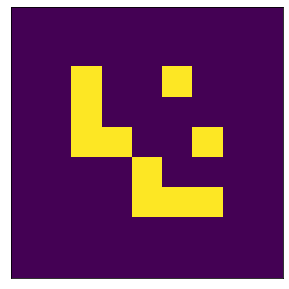

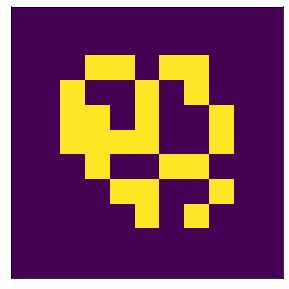

Lit pixels after 1 iterations: 24


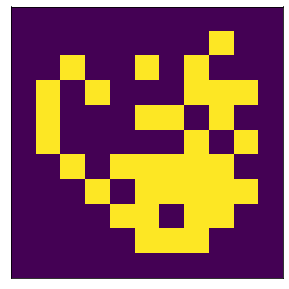

Lit pixels after 2 iterations: 35


In [5]:
en_str,image = load_image("day20_data_test.txt")

iters = 2
enhanced_image = enhance_image(image, en_str, iters, True)

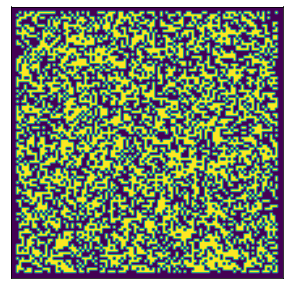

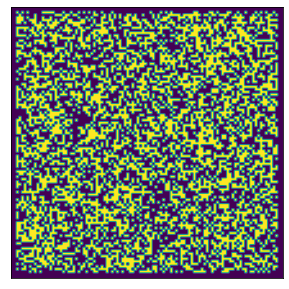

Lit pixels after 1 iterations: 4913


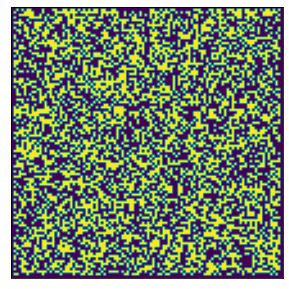

Lit pixels after 2 iterations: 5057


In [6]:
en_str,image = load_image("day20_data.txt")

iters = 2
enhanced_image = enhance_image(image, en_str, iters, True)

## Part Two

You still can't quite make out the details in the image. Maybe you just didn't enhance it enough.

If you enhance the starting input image in the above example a total of 50 times, 3351 pixels are lit in the final output image.

Start again with the original input image and apply the image enhancement algorithm 50 times. How many pixels are lit in the resulting image?

In [7]:
en_str,image = load_image("day20_data_test.txt")

iters = 50
enhanced_image = enhance_image(image, en_str, iters, False, "day_20_enhance_example.mp4")

Lit pixels after 1 iterations: 24
Lit pixels after 2 iterations: 35
Lit pixels after 3 iterations: 53
Lit pixels after 4 iterations: 63
Lit pixels after 5 iterations: 88
Lit pixels after 6 iterations: 103
Lit pixels after 7 iterations: 137
Lit pixels after 8 iterations: 145
Lit pixels after 9 iterations: 185
Lit pixels after 10 iterations: 207
Lit pixels after 11 iterations: 252
Lit pixels after 12 iterations: 271
Lit pixels after 13 iterations: 338
Lit pixels after 14 iterations: 350
Lit pixels after 15 iterations: 400
Lit pixels after 16 iterations: 442
Lit pixels after 17 iterations: 491
Lit pixels after 18 iterations: 561
Lit pixels after 19 iterations: 584
Lit pixels after 20 iterations: 671
Lit pixels after 21 iterations: 685
Lit pixels after 22 iterations: 788
Lit pixels after 23 iterations: 841
Lit pixels after 24 iterations: 884
Lit pixels after 25 iterations: 929
Lit pixels after 26 iterations: 1020
Lit pixels after 27 iterations: 1139
Lit pixels after 28 iterations: 1127
Lit

In [8]:
en_str,image = load_image("day20_data.txt")

iters = 50
enhanced_image = enhance_image(image, en_str, iters, False, "day_20_enhance.mp4")

Lit pixels after 1 iterations: 4913
Lit pixels after 2 iterations: 5057
Lit pixels after 3 iterations: 5253
Lit pixels after 4 iterations: 5442
Lit pixels after 5 iterations: 5733
Lit pixels after 6 iterations: 5743
Lit pixels after 7 iterations: 6198
Lit pixels after 8 iterations: 6290
Lit pixels after 9 iterations: 6600
Lit pixels after 10 iterations: 6698
Lit pixels after 11 iterations: 7014
Lit pixels after 12 iterations: 7183
Lit pixels after 13 iterations: 7526
Lit pixels after 14 iterations: 7621
Lit pixels after 15 iterations: 7978
Lit pixels after 16 iterations: 8041
Lit pixels after 17 iterations: 8445
Lit pixels after 18 iterations: 8659
Lit pixels after 19 iterations: 9039
Lit pixels after 20 iterations: 9198
Lit pixels after 21 iterations: 9456
Lit pixels after 22 iterations: 9721
Lit pixels after 23 iterations: 10104
Lit pixels after 24 iterations: 10292
Lit pixels after 25 iterations: 10742
Lit pixels after 26 iterations: 10656
Lit pixels after 27 iterations: 11328
Lit p